# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 49775,
  "iopub_port": 34949,
  "stdin_port": 35985,
  "control_port": 55057,
  "hb_port": 41735,
  "ip": "127.0.0.1",
  "key": "8351f4e2-186cab2db0df7b905c46fe30",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-48c8cb76-6eb9-42dd-b695-f299184793e1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/test_new/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'emu', 'mumu',  
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.1)

In [3]:
# make some control plots 
params = fit_data._parameters
params_pre = fit_data.get_params_init().copy()
asimov_data = dict()
for category, model_data in fit_data._model_data.items():
    # parse lepton selection and jet category
    cat_split = category.split('_')
    sel = cat_split[0]
    jet_cat = '_'.join(cat_split[1:])
    
    # build prefit expectation from model_tensor
    expected_pre, expected_var = fit_data.mixture_model(params_pre.values, category)
    expected_test = fit_data.model_sums(sel, jet_cat) # for testing template removal
    
    asimov_data[category] = (expected_pre, np.sqrt(expected_pre))

    # build postfit expectation from model_tensor
    params_post = params_pre.copy()
    params_post['lumi'] *= 1. # changing one normalization parameter
    params_post['top_pt'] += 0. # changing one shape parameter
    expected_post, _ = fit_data.mixture_model(params_post.values, category)

    # get the data and binning
    template_data = fit_data.get_selection_data(sel)[jet_cat]
    data_val, data_var = template_data['templates']['data']['val'], template_data['templates']['data']['var']
    bins = template_data['bins'][:-1]
    
    # test systematic uncertainties
    ntoys = 1000
    pval, perr = params['val_init'].values[4:], params['err_init'].values[4:]
    prand = pval + np.random.randn(pval.size, ntoys).T*perr 
    toy_data = np.array([fit_data.mixture_model(np.concatenate([fit_data._beta_init, p]), category)[0] for p in prand]) 
    toy_data.sort(axis=0)
    syst_err = (toy_data[int(0.16*ntoys),:], toy_data[-int(0.16*ntoys),:])

    pt.fit_plot(bins, asimov_data[category][0], expected_pre, expected_post, 
                np.sqrt(expected_var), syst_err,
                xlabel=(plot_labels[sel][0]),
                title=f'{plot_labels[sel][1]}: {pt.categories[jet_cat].label}',
                output_path=f'plots/fits/{sel}_{jet_cat}.png',
                show=False
               )

In [4]:
# initialize data for likelihood scans and calculation of the NLL covariance
fobj = partial(fit_data.objective, 
               data=asimov_data, 
               cost_type='poisson', 
               no_shape=False,
               subtract_cost_init=True
              )

# calculate covariance matrix from the inverse of the Hessian of the NLL
stderr, corr = fh.calculate_covariance(fobj, params_pre.values)

In [5]:
# plot errors
parameters = fit_data._parameters.copy()
parameters['val_fit'] = fit_data.get_params_init()
parameters['err_fit'] = stderr

# scale branching fraction values
param_mask = np.array(parameters.type == 'poi', dtype=bool)
val_init = parameters.loc[param_mask, 'val_init']
parameters.loc[param_mask, 'err_init'] *= 100/val_init
parameters.loc[param_mask, 'err_fit'] *= 100/val_init

# scale normalization values
param_mask = np.array(parameters.type == 'norm', dtype=bool)
parameters.loc[param_mask, 'err_init'] *= 100
parameters.loc[param_mask, 'err_fit'] *= 100

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', parameters.shape[0])
pd.set_option('display.max_rows', parameters.shape[0])

# plot nuisance parameter errors and constraints
parameters[4:].to_csv('local_data/pulls.csv')

parameters.set_index('label')
#parameters[['val_init', 'err_init', 'val_fit', 'err_fit']]
parameters[['err_init', 'err_fit']]


,err_init,err_fit
name,,
beta_e,100.00,0.38
beta_mu,100.00,0.28
beta_tau,100.00,0.54
beta_h,100.00,0.11
br_tau_e,0.22,0.22
br_tau_mu,0.23,0.23
br_tau_h,0.15,0.15
lumi,2.50,0.29
xs_diboson,10.00,9.46


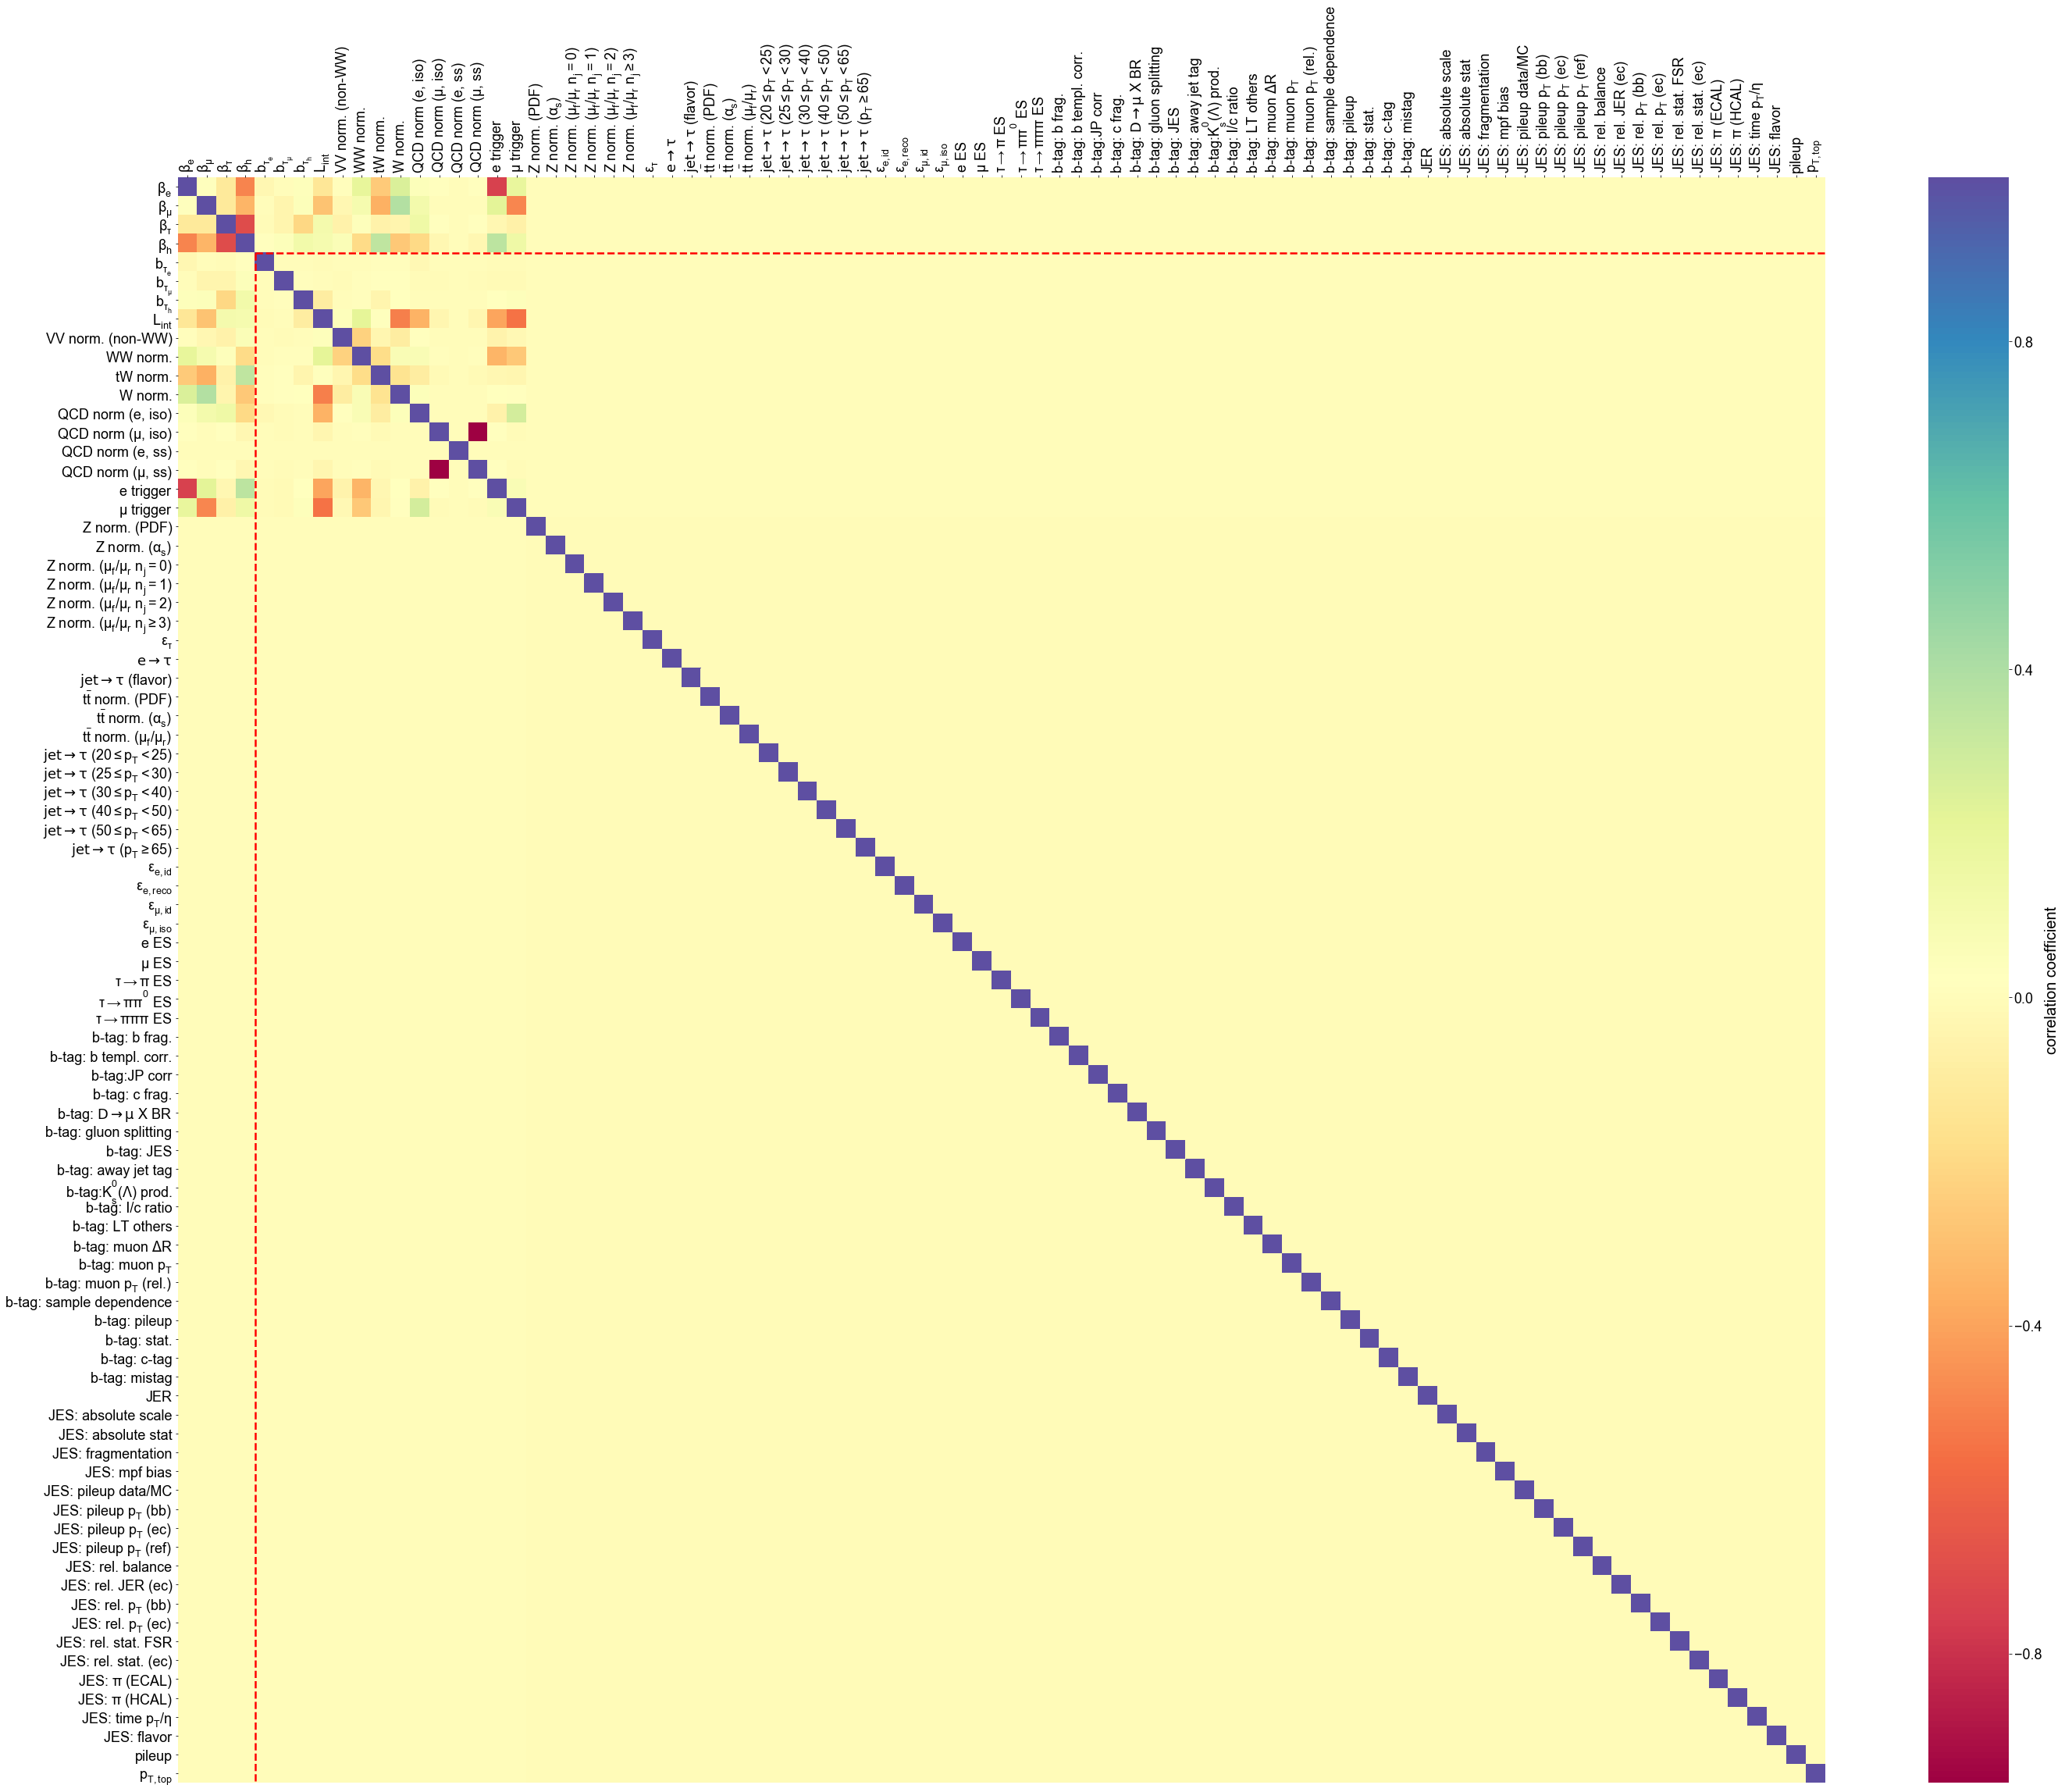

In [6]:
# produce correlation matrix
p_labels_fancy = fit_data._parameters.label
df_corr = pd.DataFrame(corr, columns=p_labels_fancy, index=p_labels_fancy)
df_corr.to_latex('local_data/corr_table_full.tex')
df_corr.to_csv('local_data/corr_table_full.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(40, 32))
sns.heatmap(df_corr, cmap='Spectral', annot=False, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.plot([4, df_corr.shape[0]], [4, 4], 'r--')
plt.plot([4, 4], [4, df_corr.shape[0]], 'r--')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('plots/systematics/correlation_matrix.pdf')
plt.show()